In [1]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
import numpy as np
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
#URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

In [2]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

#evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions


In [3]:
import numpy as np 
import scipy.sparse as sps
profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)

#profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([42, 32,  4, ...,  7, 18, 59], dtype=int32), (12638,))

In [5]:
block_size = int(len(profile_length)*0.05)
block_size

631

In [6]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 631, average p.len 0.65, median 1.0, min 0, max 1
Group 1, #users in group 631, average p.len 1.00, median 1.0, min 1, max 1
Group 2, #users in group 631, average p.len 1.94, median 2.0, min 1, max 2
Group 3, #users in group 631, average p.len 2.87, median 3.0, min 2, max 3
Group 4, #users in group 631, average p.len 4.03, median 4.0, min 3, max 5
Group 5, #users in group 631, average p.len 5.37, median 5.0, min 5, max 6
Group 6, #users in group 631, average p.len 6.77, median 7.0, min 6, max 8
Group 7, #users in group 631, average p.len 8.50, median 8.0, min 8, max 9
Group 8, #users in group 631, average p.len 10.64, median 11.0, min 9, max 12
Group 9, #users in group 631, average p.len 13.12, median 13.0, min 12, max 14
Group 10, #users in group 631, average p.len 15.95, median 16.0, min 14, max 18
Group 11, #users in group 631, average p.len 19.33, median 19.0, min 18, max 21
Group 12, #users in group 631, average p.len 23.31, median 23.0, min 21, max 26
Gro

In [4]:
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "RP3_2": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "SLIM_ELASTIC": SLIMElasticNetRecommender,
                                   "MULTVAE": MultVAERecommender,
                                   "EASE_R": EASE_R_Recommender,
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].fit()
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668)#, workers=7)
recommender_object_dict["PureSVD"].fit(num_factors=70, random_seed=42)
#recommender_object_dict["NMF"].load_model("result_experiments/", "NMFRecommender_best_model.zip")
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3beta"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["RP3_2"].fit(alpha=0.20026352123406477, beta=0.15999879728761354, topK=32)
recommender_object_dict["UserKNNCF"].fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
recommender_object_dict["ItemKNNCF"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
#recommender_object_dict["SLIM2"].fit(topK=700, l1_ratio=0.015024, alpha=0.001970400636566181, workers=7)
recommender_object_dict["EASE_R"].fit(topK=24, l2_norm=37.54323189430143)
recommender_object_dict["MULTVAE"].fit(epochs=100, learning_rate=0.0003386225308766206, l2_reg=2.129359930047709e-06, dropout=0.09838599885053126, total_anneal_steps=525579, anneal_cap=0.4033304347929101,batch_size=256)
#recommender_object_dict["MF_BPR"].fit(sgd_mode="adagrad", num_factors=219, batch_size=32, learning_rate=0.08036400470449359,positive_reg=0.016211221706684466,negative_reg=0.00012672106970228173, epochs=260, random_seed=1234)
#recommender_object_dict["SLIM_BPR"].fit(topK=46, symmetric=True, sgd_mode="adagrad", epochs=195, lambda_i=0.00035732097169170193, lambda_j=0.004542391418975173, learning_rate=0.0002291767622519941)
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
#recommender_object_dict["IALS"].fit()

/Users/alessandro/RecSys-2023-polimi/venv/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


TopPopRecommender: URM Detected 197 ( 1.6%) users with no interactions.
TopPopRecommender: URM Detected 114 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 197 ( 1.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 197 ( 1.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
P3alphaRecommender: URM Detected 197 ( 1.6%) users with no interactions.
P3alphaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 197 ( 1.6%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 197 ( 1.6%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 197 ( 1.6%) users with no interactions.
PureSVDRecommender: URM Detected 114 ( 0.5%) 

2023-12-17 01:32:43.550633: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-17 01:32:43.550858: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-17 01:32:43.550873: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-17 01:32:43.551153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-17 01:32:43.551512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-17 01:32:43.784808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-17 01:32:43.800986: I tensorflow/core/gra

MultVAERecommender: Saving model in file './result_experiments/__Temp_MultVAERecommender_32959/_best_model'
MultVAERecommender: Saving complete
MultVAERecommender: Epoch 1 of 100. Elapsed time 15.46 sec
MultVAERecommender: Epoch 2 of 100. Elapsed time 23.69 sec
MultVAERecommender: Epoch 3 of 100. Elapsed time 31.97 sec
MultVAERecommender: Epoch 4 of 100. Elapsed time 40.43 sec
MultVAERecommender: Epoch 5 of 100. Elapsed time 48.82 sec
MultVAERecommender: Epoch 6 of 100. Elapsed time 57.28 sec
MultVAERecommender: Epoch 7 of 100. Elapsed time 1.10 min
MultVAERecommender: Epoch 8 of 100. Elapsed time 1.24 min
MultVAERecommender: Epoch 9 of 100. Elapsed time 1.38 min
MultVAERecommender: Epoch 10 of 100. Elapsed time 1.52 min
MultVAERecommender: Epoch 11 of 100. Elapsed time 1.67 min
MultVAERecommender: Epoch 12 of 100. Elapsed time 1.81 min
MultVAERecommender: Epoch 13 of 100. Elapsed time 1.95 min
MultVAERecommender: Epoch 14 of 100. Elapsed time 2.09 min
MultVAERecommender: Epoch 15 of 1

2023-12-17 01:46:39.443511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-17 01:46:39.443533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Restoring parameters from ./result_experiments/__Temp_MultVAERecommender_32959/_best_model/.session/session
MultVAERecommender: Loading complete
MultVAERecommender: Cleaning temporary files from './result_experiments/__Temp_MultVAERecommender_32959/'


In [5]:
from Hybrid import *


recommender_object_dict["hybrid"] = ScoresHybridRecommender(URM_train_validation, recommender_object_dict["SLIM_ELASTIC"], recommender_object_dict["RP3_2"], recommender_object_dict["ItemKNNCF"])
recommender_object_dict["hybrid"].fit(alpha=0.5072513954300486, beta=0.30902582824263064)

ScoresHybridRecommender: URM Detected 197 ( 1.6%) users with no interactions.
ScoresHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [26]:
recommender_object_dict["userknn2"] = UserKNNCFRecommender(URM_train_validation)
recommender_object_dict["userknn2"].fit(topK=777, shrink=100, similarity='cosine', normalize=False,
                                       feature_weighting='TF-IDF')

UserKNNCFRecommender: URM Detected 229 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 116 ( 0.5%) items with no interactions.
Similarity column 12638 (100.0%), 9962.18 column/sec. Elapsed time 1.27 sec


In [29]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender

new_similarity = ((1 - 0.10204960939360941) * recommender_object_dict["SLIM_ELASTIC"].W_sparse + 
                  0.10204960939360941 * recommender_object_dict["ItemKNNCF"].W_sparse)
recommender = ItemKNNCustomSimilarityRecommender(URM_train_validation)
recommender.fit(W_sparse=new_similarity)
recommender_object_dict["CustomSimilarity"] = recommender

ItemKNNCustomSimilarityRecommender: URM Detected 222 ( 1.8%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 113 ( 0.5%) items with no interactions.


In [19]:
# EQUAL SIZE GROUPING
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]


Group 0, #users in group 631, average p.len 0.61, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2154 (17.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12007 Users
EvaluatorHoldout: Processed 353 (100.0%) in 0.22 sec. Users per second: 1599
EvaluatorHoldout: Processed 353 (100.0%) in 0.23 sec. Users per second: 1547
EvaluatorHoldout: Processed 353 (100.0%) in 0.18 sec. Users per second: 1960
EvaluatorHoldout: Processed 353 (100.0%) in 0.17 sec. Users per second: 2088
EvaluatorHoldout: Processed 353 (100.0%) in 0.17 sec. Users per second: 2079
EvaluatorHoldout: Processed 353 (100.0%) in 0.21 sec. Users per second: 1647
EvaluatorHoldout: Processed 353 (100.0%) in 0.17 sec. Users per second: 2024
EvaluatorHoldout: Processed 353 (100.0%) in 0.18 sec. Users per second: 2012
Group 1, #users in group 631, average p.len 1.01, median 1.0, min 1, max 2
EvaluatorHoldout: Ignoring 2154 (17.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignor

In [6]:
# PROFILE LENGTH BASED GROUPING
from Evaluation.Evaluator import EvaluatorHoldout
import numpy as np

MAP_recommender_per_group = {}
cutoff = 10

# Define the cutoffs for profile length for each group
profile_length_cutoffs = [2, 3, 4, 6, 8, 25, 80, 100, 250, 1500]
#profile_length_cutoffs = [2, 4, 6, 8, 25, 40, 65, 130, 200, 1500]
#profile_length_cutoffs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
#                          27, 28, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 60, 80, 100, 150, 200, 1500]

for group_id in range(len(profile_length_cutoffs)):

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if group_id == 0:
        users_in_group_flag = profile_length < profile_length_cutoffs[group_id]
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[group_id - 1],
                                             profile_length < profile_length_cutoffs[group_id])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    if len(users_in_group) > 0:
        users_in_group_p_len = profile_length[users_in_group]

        print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

        # Select users not in the current group
        users_not_in_group_flag = np.isin(np.arange(len(profile_length)), users_in_group, invert=True)
        users_not_in_group = np.arange(len(profile_length))[users_not_in_group_flag]

        evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

        for label, recommender in recommender_object_dict.items():
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
            if label in MAP_recommender_per_group:
                MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            else:
                MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
    else:
        print(f"Group {group_id} has no users.")

Group 0, #users in group 1266, average p.len 0.84, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11372 Users
EvaluatorHoldout: Processed 491 (100.0%) in 0.25 sec. Users per second: 1937
EvaluatorHoldout: Processed 491 (100.0%) in 0.30 sec. Users per second: 1649
EvaluatorHoldout: Processed 491 (100.0%) in 0.22 sec. Users per second: 2255
EvaluatorHoldout: Processed 491 (100.0%) in 0.21 sec. Users per second: 2317
EvaluatorHoldout: Processed 491 (100.0%) in 0.21 sec. Users per second: 2292
EvaluatorHoldout: Processed 491 (100.0%) in 0.20 sec. Users per second: 2433
EvaluatorHoldout: Processed 491 (100.0%) in 0.26 sec. Users per second: 1858
EvaluatorHoldout: Processed 491 (100.0%) in 0.22 sec. Users per second: 2192
EvaluatorHoldout: Processed 491 (100.0%) in 1.32 sec. Users per second: 371
EvaluatorHoldout: Processed 491 (100.0%) in 0.20 sec. Users per second: 2497
EvaluatorHoldout: Processed 49

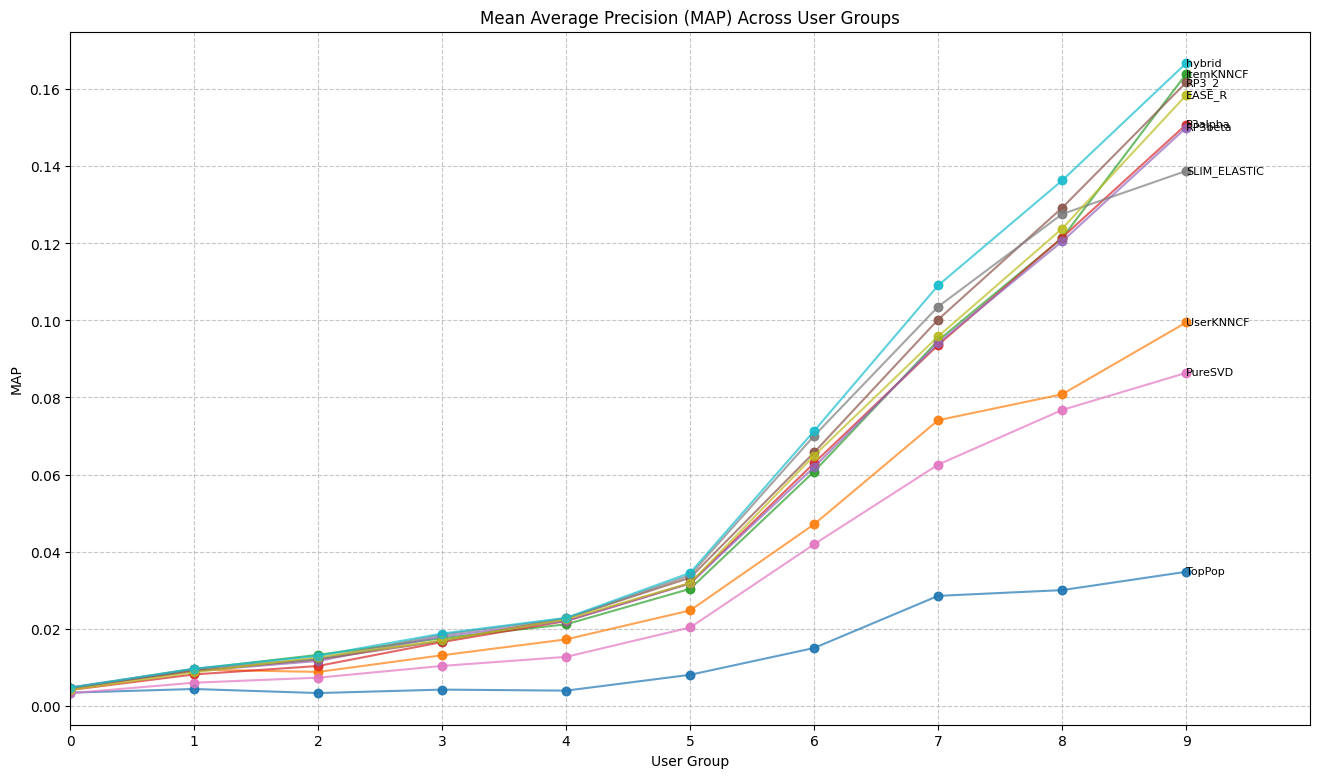

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, len(results)))

# Set x-axis limits to 0 and 4
plt.xlim(0, len(results))

plt.show()

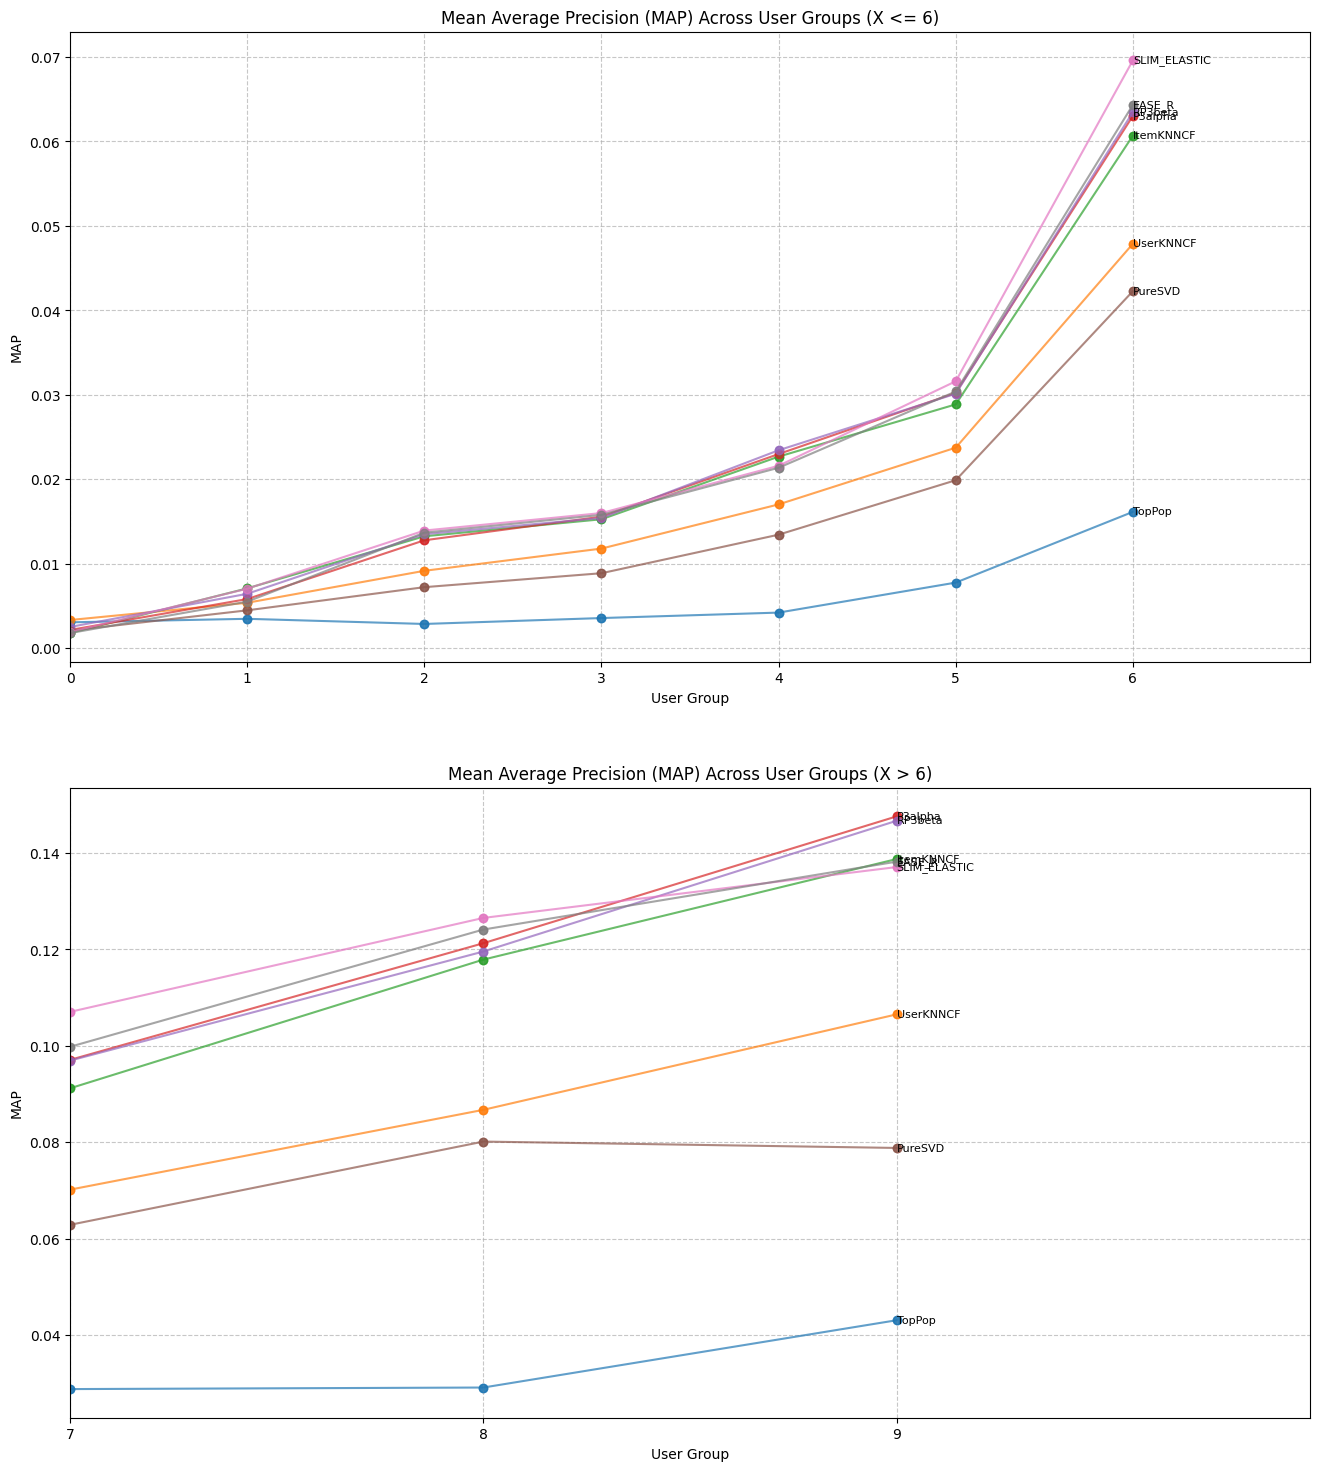

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, figsize=(16, 18))

# Plot for X values <= 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[:7]  # Get values for X <= 6
    axs[0].scatter(x=np.arange(0, len(results_cutoff)), y=results_cutoff, label=label, alpha=0.7)
    axs[0].plot(np.arange(0, len(results_cutoff)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[0].text(len(results_cutoff)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[0].set_title('Mean Average Precision (MAP) Across User Groups (X <= 6)')
axs[0].set_xlabel('User Group')
axs[0].set_ylabel('MAP')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_xticks(np.arange(0, len(results_cutoff)))
axs[0].set_xlim(0, len(results_cutoff))

# Plot for X values > 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[7:]  # Get values for X > 6
    axs[1].scatter(x=np.arange(7, len(results)), y=results_cutoff, label=label, alpha=0.7)
    axs[1].plot(np.arange(7, len(results)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[1].text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[1].set_title('Mean Average Precision (MAP) Across User Groups (X > 6)')
axs[1].set_xlabel('User Group')
axs[1].set_ylabel('MAP')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_xticks(np.arange(7, len(results)))
axs[1].set_xlim(7, len(results))

plt.show()

In [7]:
import pandas as pd
print(pd.DataFrame(MAP_recommender_per_group))

     TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3beta     RP3_2   PureSVD  \
0  0.003036   0.003491   0.003489  0.002325  0.002648  0.002699  0.002047   
1  0.003868   0.007855   0.008711  0.006933  0.007027  0.007791  0.003568   
2  0.003302   0.010983   0.013691  0.014200  0.014944  0.014549  0.009852   
3  0.003595   0.011801   0.016306  0.016239  0.016649  0.016786  0.009107   
4  0.005329   0.016533   0.019518  0.020397  0.020585  0.020228  0.010438   
5  0.007900   0.024783   0.029611  0.031098  0.031674  0.032087  0.020859   
6  0.015362   0.047902   0.061317  0.064498  0.063226  0.066980  0.041828   
7  0.028305   0.072757   0.090542  0.089334  0.089687  0.094574  0.066018   
8  0.027146   0.080153   0.117407  0.119975  0.116644  0.125079  0.075669   
9  0.041805   0.096761   0.157442  0.150259  0.148711  0.156621  0.081245   

   SLIM_ELASTIC   MULTVAE    EASE_R    hybrid  
0      0.002957  0.004804  0.002315  0.003348  
1      0.006421  0.007772  0.006213  0.007916  
2      0

In [9]:
pd.DataFrame(MAP_recommender_per_group)

,TopPop,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,RP3_2,PureSVD,SLIM_ELASTIC,MULTVAE,EASE_R,hybrid
0,0.003036,0.003491,0.003489,0.002325,0.002648,0.002699,0.002047,0.002957,0.004804,0.002315,0.003348
1,0.003868,0.007855,0.008711,0.006933,0.007027,0.007791,0.003568,0.006421,0.007772,0.006213,0.007916
2,0.003302,0.010983,0.013691,0.014200,0.014944,0.014549,0.009852,0.014546,0.008829,0.013888,0.014651
3,0.003595,0.011801,0.016306,0.016239,0.016649,0.016786,0.009107,0.016765,0.009326,0.017053,0.017574
4,0.005329,0.016533,0.019518,0.020397,0.020585,0.020228,0.010438,0.019949,0.013125,0.018377,0.019996
5,0.007900,0.024783,0.029611,0.031098,0.031674,0.032087,0.020859,0.032694,0.020775,0.031645,0.033246
6,0.015362,0.047902,0.061317,0.064498,0.063226,0.066980,0.041828,0.070498,0.035684,0.066118,0.071573
7,0.028305,0.072757,0.090542,0.089334,0.089687,0.094574,0.066018,0.101505,0.047606,0.094012,0.103565
8,0.027146,0.080153,0.117407,0.119975,0.116644,0.125079,0.075669,0.127916,0.056877,0.126902,0.134099
9,0.041805,0.096761,0.157442,0.150259,0.148711,0.156621,0.081245,0.146175,0.067844,0.152716,0.158823


In [8]:
df = pd.DataFrame(MAP_recommender_per_group)
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Sort the row in descending order and get the column labels
    sorted_row = row.sort_values(ascending=False)
    
    # Get the column label of the max value in the row
    max_column = sorted_row.index[0]
    # Get the max value in the row
    max_value = sorted_row.iloc[0]
    
    # Get the column label of the second max value in the row
    second_max_column = sorted_row.index[1]
    # Get the second max value in the row
    second_max_value = sorted_row.iloc[1]
    
    print(f"Row {index}: Max value is {max_value} at {max_column}, Second max value is {second_max_value} at {second_max_column}")

Row 0: Max value is 0.004804415995862026 at MULTVAE, Second max value is 0.003490770374680761 at UserKNNCF
Row 1: Max value is 0.008711256321666413 at ItemKNNCF, Second max value is 0.00791572780531771 at hybrid
Row 2: Max value is 0.014943772702393384 at RP3beta, Second max value is 0.014650942926804989 at hybrid
Row 3: Max value is 0.017573660322475478 at hybrid, Second max value is 0.017053085583891254 at EASE_R
Row 4: Max value is 0.020584693521014278 at RP3beta, Second max value is 0.020397012578616355 at P3alpha
Row 5: Max value is 0.03324602718874874 at hybrid, Second max value is 0.03269384402243993 at SLIM_ELASTIC
Row 6: Max value is 0.07157302192964039 at hybrid, Second max value is 0.07049769149416939 at SLIM_ELASTIC
Row 7: Max value is 0.1035645584676592 at hybrid, Second max value is 0.10150527049751862 at SLIM_ELASTIC
Row 8: Max value is 0.1340992179184599 at hybrid, Second max value is 0.12791620389652458 at SLIM_ELASTIC
Row 9: Max value is 0.1588233458177278 at hybrid, 

In [41]:
df = pd.DataFrame(MAP_recommender_per_group)
df

,TopPop,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,PureSVD,SLIM_ELASTIC,EASE_R
0,0.004055,0.002642,0.001535,0.001263,0.001755,0.001576,0.001886,0.001634
1,0.005041,0.010618,0.011383,0.011860,0.012618,0.007394,0.011069,0.011045
2,0.002275,0.011077,0.013158,0.012645,0.012693,0.009447,0.012319,0.012794
3,0.004557,0.013558,0.015557,0.016360,0.017321,0.010044,0.017341,0.016821
4,0.004955,0.015554,0.019829,0.021305,0.020901,0.012760,0.020577,0.019744
5,0.007936,0.023355,0.029559,0.029831,0.029767,0.019490,0.032188,0.030294
6,0.015224,0.050343,0.063745,0.067151,0.066289,0.045224,0.070696,0.068119
7,0.023094,0.067833,0.088864,0.091369,0.090260,0.064556,0.101845,0.099314
8,0.028859,0.084978,0.116480,0.117578,0.115418,0.075790,0.123984,0.121936
9,0.041293,0.113101,0.143412,0.157755,0.152869,0.083683,0.141814,0.144672


In [12]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(MAP_recommender_per_group)
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.00470673841675974 at RP3beta, Second max value is 0.004705892307171626 at hybrid, Min profile length is 1, Max profile length is 1, Number of users in group is 1004, diff with slim is 6.447355061427618e-05, improvement: 0.06473144481673329
Row 1: Max value is 0.009609139156685166 at hybrid, Second max value is 0.00958990651475314 at SLIM_ELASTIC, Min profile length is 2, Max profile length is 2, Number of users in group is 764, diff with slim is 1.9232641932025868e-05, improvement: 0.014693738436067763
Row 2: Max value is 0.013201676309152944 at ItemKNNCF, Second max value is 0.012964199179152452 at hybrid, Min profile length is 3, Max profile length is 3, Number of users in group is 608, diff with slim is 0.001059190031152648, improvement: 0.64398753894081
Row 3: Max value is 0.018720268433571167 at hybrid, Second max value is 0.018450803359060228 at SLIM_ELASTIC, Min profile length is 4, Max profile length is 5, Number of users in group is 962, diff with slim is

In [31]:
# Create an empty DataFrame with the columns you want
df_print = pd.DataFrame(columns=['Row', 'Max Value', 'Max Index', 'Second Max Value', 'Second Max Index', 'Min Profile Length', 'Max Profile Length', 'Number of Users in Group', 'Diff with SLIM', 'Improvement'])

for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    # Calculate the difference with SLIM and the improvement
    diff_with_slim = max_value - df['SLIM_ELASTIC'][index]
    improvement = diff_with_slim * num_users_in_group

    # Add the values to the DataFrame
    df_print = df_print.append({
        'Row': index,
        'Max Value': max_value,
        'Max Index': max_index,
        'Second Max Value': second_max_value,
        'Second Max Index': second_max_index,
        'Min Profile Length': min_profile_length,
        'Max Profile Length': max_profile_length,
        'Number of Users in Group': num_users_in_group,
        'Diff with SLIM': diff_with_slim,
        'Improvement': improvement
    }, ignore_index=True)

# Print the DataFrame
df_print

,Row,Max Value,Max Index,Second Max Value,Second Max Index,Min Profile Length,Max Profile Length,Number of Users in Group,Diff with SLIM,Improvement
0,0,0.002899,TopPop,0.002782,ItemKNNCF,1,1,1038,0.000137,0.141860
1,1,0.010353,UserKNNCF,0.010125,RP3beta,2,2,723,0.001569,1.134091
2,2,0.012208,ItemKNNCF,0.011519,RP3beta,3,3,611,0.001020,0.623346
3,3,0.015080,RP3beta,0.015035,SLIM_ELASTIC,4,4,481,0.000045,0.021841
4,4,0.016718,RP3beta,0.015783,ItemKNNCF,5,5,467,0.001657,0.773672
5,5,0.019064,ItemKNNCF,0.018986,SLIM_ELASTIC,6,6,443,0.000078,0.034658
6,6,0.021862,P3alpha,0.021470,RP3beta,7,7,364,0.000629,0.228877
7,7,0.026343,SLIM_ELASTIC,0.024240,RP3beta,8,8,353,0.000000,0.000000
8,8,0.024286,ItemKNNCF,0.023981,P3alpha,9,9,344,0.001282,0.440980
9,9,0.026790,SLIM_ELASTIC,0.024519,RP3beta,10,10,305,0.000000,0.000000


In [12]:
import pandas as pd
import numpy as np

def load_csv_files(file_paths):
    """Load multiple CSV files into a list of dataframes, skipping the first column."""
    return [pd.read_csv(fp).iloc[:, 1:] for fp in file_paths]

def check_structure(dataframes):
    """Check if all dataframes have the same structure."""
    return all(df.shape == dataframes[0].shape and all(df.columns == dataframes[0].columns) for df in dataframes)

def average_scores(dataframes):
    """Calculate the average score for each recommender across all dataframes."""
    return sum(dataframes) / len(dataframes)

# Paths to your CSV files
file_paths = [
    'result_1.csv',
    'result_2.csv',
    'result_3.csv',
    'result_4.csv',
    'result_5.csv',
    'result_6.csv',
    'result_7.csv',
    'result_8.csv',
    'result_9.csv',
    'result_10.csv',
    'result_11.csv',
    # 'result_12.csv',
    # 'result_13.csv',
    # 'result_14.csv',
    # 'result_15.csv',
    # 'result_16.csv',
    # 'result_17.csv',
    # 'result_18.csv',
    # 'result_19.csv',
    # 'result_20.csv',
    # 'result_21.csv',
    # 'result_22.csv',
    # 'result_23.csv',
    # 'result_24.csv',
    # 'result_25.csv',
    # 'result_26.csv',
    # 'result_27.csv',
    # 'result_28.csv',
    # 'result_29.csv',
    # 'result_30.csv',
    # 'result_31.csv',
    # 'result_32.csv',
    # 'result_33.csv',
    # 'result_34.csv',
    # 'result_35.csv',
    # 'result_36.csv',
    # 'result_37.csv',
    # 'result_38.csv',
    # 'result_39.csv',
    # 'result_40.csv',
    # 'result_41.csv',
]

# Load the CSV files
dataframes = load_csv_files(file_paths)

# Check if all CSV files have the same structure
if check_structure(dataframes):
    # Calculate the average
    avg_df = average_scores(dataframes)
    print(avg_df)
else:
    print("CSV files do not have the same structure.")


     TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3beta   PureSVD  SLIM_ELASTIC  \
0  0.003083   0.003543   0.002983  0.002885  0.003103  0.002412      0.003023   
1  0.003310   0.009390   0.009450  0.009687  0.010313  0.007082      0.009846   
2  0.003538   0.010438   0.012021  0.012150  0.012699  0.007664      0.012371   
3  0.003791   0.012330   0.014727  0.015079  0.015655  0.009353      0.015170   
4  0.004486   0.015122   0.019717  0.020018  0.020579  0.011939      0.020826   
5  0.007687   0.024146   0.028947  0.030643  0.030593  0.019914      0.032387   
6  0.015160   0.048499   0.060908  0.064576  0.063565  0.042724      0.070497   
7  0.027485   0.073199   0.091002  0.095361  0.094422  0.065065      0.107778   
8  0.028939   0.085034   0.116024  0.120429  0.117632  0.077025      0.126579   
9  0.042612   0.104175   0.155814  0.160164  0.155820  0.082987      0.143549   

     hybrid  
0  0.003158  
1  0.010146  
2  0.012734  
3  0.015721  
4  0.021294  
5  0.032429  
6  0.06973

In [13]:
avg_df

,TopPop,UserKNNCF,ItemKNNCF,P3alpha,RP3beta,PureSVD,SLIM_ELASTIC,hybrid
0,0.003083,0.003543,0.002983,0.002885,0.003103,0.002412,0.003023,0.003158
1,0.003310,0.009390,0.009450,0.009687,0.010313,0.007082,0.009846,0.010146
2,0.003538,0.010438,0.012021,0.012150,0.012699,0.007664,0.012371,0.012734
3,0.003791,0.012330,0.014727,0.015079,0.015655,0.009353,0.015170,0.015721
4,0.004486,0.015122,0.019717,0.020018,0.020579,0.011939,0.020826,0.021294
5,0.007687,0.024146,0.028947,0.030643,0.030593,0.019914,0.032387,0.032429
6,0.015160,0.048499,0.060908,0.064576,0.063565,0.042724,0.070497,0.069735
7,0.027485,0.073199,0.091002,0.095361,0.094422,0.065065,0.107778,0.105800
8,0.028939,0.085034,0.116024,0.120429,0.117632,0.077025,0.126579,0.130056
9,0.042612,0.104175,0.155814,0.160164,0.155820,0.082987,0.143549,0.165175


In [16]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(avg_df)
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]
    
    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.0035434061535169546 at UserKNNCF, Second max value is 0.003158382356194518 at hybrid, Min profile length is 1, Max profile length is 1, Number of users in group is 1026, diff with slim is 0.0005202196148054086, improvement: 0.5337453247903492
Row 1: Max value is 0.010312554901606198 at RP3beta, Second max value is 0.010146400775302301 at hybrid, Min profile length is 2, Max profile length is 2, Number of users in group is 738, diff with slim is 0.00046695489172934347, improvement: 0.3446127100962555
Row 2: Max value is 0.012734452193956346 at hybrid, Second max value is 0.01269871528694958 at RP3beta, Min profile length is 3, Max profile length is 3, Number of users in group is 615, diff with slim is 0.0003632350680307806, improvement: 0.22338956683893008
Row 3: Max value is 0.015720515025641927 at hybrid, Second max value is 0.015655200674204894 at RP3beta, Min profile length is 4, Max profile length is 5, Number of users in group is 972, diff with slim is 0.0005

In [17]:
# Load the target users test file into a DataFrame
target_users_test_df = pd.read_csv('data_target_users_test.csv')

# Convert the user ids in the DataFrame to a set for faster lookup
target_users_test_set = set(target_users_test_df['user_id'])

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]
    
    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    # Calculate the number of users in the group that are also in the target users test set
    num_users_in_test_group = sum(user in target_users_test_set for user in users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, Number of users in test group is {num_users_in_test_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.0035434061535169546 at UserKNNCF, Second max value is 0.003158382356194518 at hybrid, Min profile length is 1, Max profile length is 1, Number of users in group is 1026, Number of users in test group is 862, diff with slim is 0.0005202196148054086, improvement: 0.5337453247903492
Row 1: Max value is 0.010312554901606198 at RP3beta, Second max value is 0.010146400775302301 at hybrid, Min profile length is 2, Max profile length is 2, Number of users in group is 738, Number of users in test group is 610, diff with slim is 0.00046695489172934347, improvement: 0.3446127100962555
Row 2: Max value is 0.012734452193956346 at hybrid, Second max value is 0.01269871528694958 at RP3beta, Min profile length is 3, Max profile length is 3, Number of users in group is 615, Number of users in test group is 515, diff with slim is 0.0003632350680307806, improvement: 0.22338956683893008
Row 3: Max value is 0.015720515025641927 at hybrid, Second max value is 0.015655200674204894 at RP